In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_context('talk')

**Note:**

Data source: [hotel demand datasets](https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-mmc2.zip) from Antonio, et al. (2019).

Paper: Antonio, N., De Almeida, A., & Nunes, L. (2019). Hotel booking demand datasets. Data in Brief, 22, 41-49. https://doi.org/10.1016/j.dib.2018.11.126

In [2]:
df_h1 = pd.read_csv("H1.csv")
df_h2 = pd.read_csv("H2.csv")

# 3. Data Preparation

## 3.1. Select the Data

### 3.1.1. Select Rows

Remove invalid records:

- bookings with negative ADR
- cancelled city hotel booking with ADR = 5400
- bookings with "Undefined" distribution channel
- two cancelled city hotel bookings with "Undefined" market segment, which will be discarded alongside with bookings with "Undefined" distribution channel

In [3]:
## 1. remove bookings with negative ADR in H1
mask_nonnegative_adr_h1 = (df_h1['ADR'] >= 0)

df_h1 = df_h1[mask_nonnegative_adr_h1].copy()

In [4]:
## 2. remove extremely high ADR (and it's cancelled anyway)
mask_adr5400_h2 = (df_h2['ADR'] == 5400)

df_h2 = df_h2[~mask_adr5400_h2].copy()

In [5]:
## 3. remove bookings with Undefined distribution channel
mask_undefined_distchannel_h1 = (df_h1['DistributionChannel'] == 'Undefined')
mask_undefined_distchannel_h2 = (df_h2['DistributionChannel'] == 'Undefined')

df_h1 = df_h1[~mask_undefined_distchannel_h1].copy()
df_h2 = df_h2[~mask_undefined_distchannel_h2].copy()

In [6]:
df_h1.shape

(40058, 31)

In [7]:
df_h2.shape

(79325, 31)

### 3.1.2. Select Columns

Exclude BookingChanges, ReservationStatus, ReservationStatusDate

In [8]:
df_h1.drop(
    labels = ['BookingChanges','ReservationStatus','ReservationStatusDate'],
    axis = 1,
    inplace = True
)

df_h2.drop(
    labels = ['BookingChanges','ReservationStatus','ReservationStatusDate'],
    axis = 1,
    inplace = True
)

## 3.2. Clean the Data

### 3.2.1. Inconsistent Coding Scheme

Clean Meal values: remove white spaces, convert Undefined to SC

In [9]:
def clean_meal(series):
    """
    Reclassify "Undefined" as "SC".
    """
    ## remove whitespaces
    series = series.str.replace(' ','')
    series = series.apply(lambda x: 'SC' if (x == 'Undefined') else x)
    return series

In [10]:
df_h1['Meal'] = clean_meal(df_h1['Meal'])
df_h2['Meal'] = clean_meal(df_h2['Meal'])

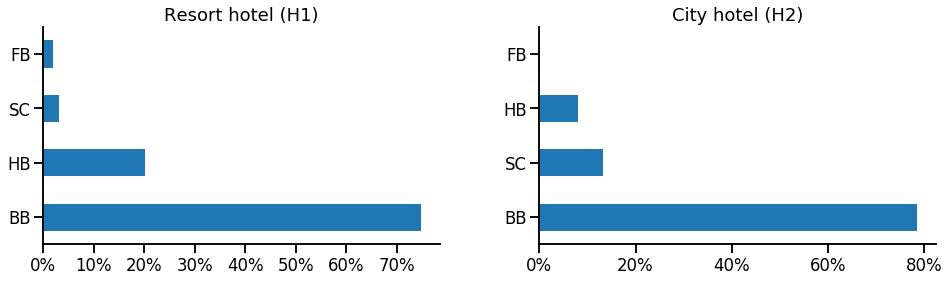

In [11]:
f, ax = plt.subplots(figsize = (16, 4), ncols = 2)
plt.subplots_adjust(wspace = .25)

df_h1['Meal'].value_counts(True).plot.barh(ax = ax[0]);
df_h2['Meal'].value_counts(True).plot.barh(ax = ax[1]);

ax[0].set_title('Resort hotel (H1)')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax[1].set_title('City hotel (H2)')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.despine();
plt.show();

Remove trailing whitespaces in AssignedRoomType and ReservedRoomType.

In [12]:
df_h1['AssignedRoomType'] = df_h1['AssignedRoomType'].str.replace(' ','')
df_h2['AssignedRoomType'] = df_h2['AssignedRoomType'].str.replace(' ','')

df_h1['ReservedRoomType'] = df_h1['ReservedRoomType'].str.replace(' ','')
df_h2['ReservedRoomType'] = df_h2['ReservedRoomType'].str.replace(' ','')

### 3.2.2. Data Errors

Remove records with extremely high ADR and "Undefined" values.

Have been removed in Select Data > Select Rows section.

### 3.2.3. Missing Values

Impute missing children as 0

In [13]:
mask_children_na_h2 = df_h2['Children'].isnull()
df_h2.loc[mask_children_na_h2, 'Children'] = 0

In [14]:
df_h2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79325 entries, 0 to 79329
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79325 non-null  int64  
 1   LeadTime                     79325 non-null  int64  
 2   ArrivalDateYear              79325 non-null  int64  
 3   ArrivalDateMonth             79325 non-null  object 
 4   ArrivalDateWeekNumber        79325 non-null  int64  
 5   ArrivalDateDayOfMonth        79325 non-null  int64  
 6   StaysInWeekendNights         79325 non-null  int64  
 7   StaysInWeekNights            79325 non-null  int64  
 8   Adults                       79325 non-null  int64  
 9   Children                     79325 non-null  float64
 10  Babies                       79325 non-null  int64  
 11  Meal                         79325 non-null  object 
 12  Country                      79301 non-null  object 
 13  MarketSegment   

## 3.3. Construct the Data

Create HasChild, HasBaby, RequireCarPark, HasSpecialRequest.

In [15]:
df_h1['HasChild'] = (df_h1['Children'] > 0)
df_h1['HasBaby'] = (df_h1['Babies'] > 0)
df_h1['RequireCarPark'] = (df_h1['RequiredCarParkingSpaces'] > 0)
df_h1['HasSpecialRequest'] = (df_h1['TotalOfSpecialRequests'] > 0)

df_h2['HasChild'] = (df_h2['Children'] > 0)
df_h2['HasBaby'] = (df_h2['Babies'] > 0)
df_h2['RequireCarPark'] = (df_h2['RequiredCarParkingSpaces'] > 0)
df_h2['HasSpecialRequest'] = (df_h2['TotalOfSpecialRequests'] > 0)

Create IsReservedRoomTypeEqualToAssigned.

In [16]:
df_h1['IsReservedRoomTypeEqualToAssigned'] = df_h1['ReservedRoomType'] == df_h1['AssignedRoomType']
df_h2['IsReservedRoomTypeEqualToAssigned'] = df_h2['ReservedRoomType'] == df_h2['AssignedRoomType']

## 3.4. Integrate Various Data Sources

Append dataframes.

In [17]:
df_h1['IsCityHotel'] = False
df_h2['IsCityHotel'] = True

df_hotel = pd.concat([df_h1, df_h2]).reset_index().drop(labels = ['index'], axis = 1)
df_hotel.shape

(119383, 34)

## 3.5. Format the Data as Required

Restructure categorical values as boolean:
- Meal
- DistributionChannel
- MarketSegment
- CustomerType
- DepositType

In [18]:
from sklearn.preprocessing import LabelBinarizer

def restructure_categories(series):
    lbin = LabelBinarizer()
    out = lbin.fit_transform(series)
    colnames = lbin.classes_.tolist()
    df_out = pd.DataFrame(data = out, columns = [series.name + '_' + colname for colname in colnames])
    ## remove the last column
    df_out.drop(df_out.columns[-1], axis = 1, inplace = True)
    return df_out

In [19]:
meal_enc = restructure_categories(df_hotel['Meal'])
market_enc = restructure_categories(df_hotel['MarketSegment'])
dist_enc = restructure_categories(df_hotel['DistributionChannel'])
deposit_enc = restructure_categories(df_hotel['DepositType'])
customer_enc = restructure_categories(df_hotel['CustomerType'])

In [20]:
df_hotel = pd.concat([
    df_hotel,
    meal_enc,
    market_enc,
    dist_enc,
    customer_enc
], axis = 1)

df_hotel.shape

(119383, 49)

In [21]:
df_hotel.iloc[0]

IsCanceled                                         0
LeadTime                                         342
ArrivalDateYear                                 2015
ArrivalDateMonth                                July
ArrivalDateWeekNumber                             27
ArrivalDateDayOfMonth                              1
StaysInWeekendNights                               0
StaysInWeekNights                                  0
Adults                                             2
Children                                           0
Babies                                             0
Meal                                              BB
Country                                          PRT
MarketSegment                                 Direct
DistributionChannel                           Direct
IsRepeatedGuest                                    0
PreviousCancellations                              0
PreviousBookingsNotCanceled                        0
ReservedRoomType                              

Convert ArrivalDateMonth.

In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
month_array = np.array(df_hotel['ArrivalDateMonth'])
month_enc = ohe.fit_transform(np.reshape(month_array, (-1,1))).toarray()
month_enc = pd.DataFrame(
    data = month_enc, 
    columns = ['ArrivalDateMonth_' + col for col in ohe.categories_[0]]
)
month_enc.drop(
    month_enc.columns[-1], 
    axis = 1,
    inplace = True
)
df_hotel = pd.concat([df_hotel, month_enc], axis = 1)

df_hotel.shape

(119383, 60)

In [23]:
## determine the right data types!
## IsCanceled should be boolean
## ... most columns we constructed should be boolean

excluded_cols = [
    'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth','ArrivalDateYear',
    'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'LeadTime',
    'PreviousCancellations', 'PreviousBookingsNotCanceled', 'DaysInWaitingList'
]

mask_actual_integer_cols = df_hotel.columns.isin(excluded_cols)
mask_all_integer_cols = df_hotel.columns.isin(df_hotel.select_dtypes(include = 'int64').columns)
## columns with underscore are the dummy variables
mask_with_underscore_cols = df_hotel.columns.str.contains('_')
boolean_cols = df_hotel.loc[:, 
                            (~mask_actual_integer_cols & mask_all_integer_cols) | (mask_with_underscore_cols)
                           ].columns

for col in boolean_cols:
    df_hotel[col] = df_hotel[col].astype(bool)

In [24]:
print(df_hotel.dtypes)

IsCanceled                              bool
LeadTime                               int64
ArrivalDateYear                        int64
ArrivalDateMonth                      object
ArrivalDateWeekNumber                  int64
ArrivalDateDayOfMonth                  int64
StaysInWeekendNights                   int64
StaysInWeekNights                      int64
Adults                                 int64
Children                             float64
Babies                                  bool
Meal                                  object
Country                               object
MarketSegment                         object
DistributionChannel                   object
IsRepeatedGuest                         bool
PreviousCancellations                  int64
PreviousBookingsNotCanceled            int64
ReservedRoomType                      object
AssignedRoomType                      object
DepositType                           object
Agent                                 object
Company   

In [25]:
df_hotel.to_csv("hotel_merged_data_preparation.csv", index = False)

# 4. Data Transformation

## 4.1. Reduce the Data

### 4.1.1. Feature Selection based on Logical Process

- Remove Country to avoid bias
- Remove Agent, Company (those are IDs)
- Remove ArrivalDateYear
- Remove redundant features (after variable constructions)

In [26]:
## remove country, agent, company
df_hotel.drop(labels = ['Country','Agent','Company','ArrivalDateYear'], axis = 1, inplace = True)

In [27]:
## remove redundant features (already represented using dummy variables)
drop_cols = ['Children','Babies','Meal','MarketSegment','DistributionChannel','CustomerType',
            'DepositType','RequiredCarParkingSpaces','TotalOfSpecialRequests','ArrivalDateMonth',
            'AssignedRoomType','ReservedRoomType']

df_hotel.drop(labels = drop_cols, axis = 1, inplace = True)

In [28]:
df_hotel.shape

(119383, 44)

### 4.1.2. Feature Selection

Use recursive feature elimination (RFE).

In [29]:
## split training and test set first
from sklearn.model_selection import train_test_split

TEST_PROPORTION = 0.3
RND = 722
target_class = 'IsCanceled'
features = df_hotel.columns[(df_hotel.columns != target_class)]
X_train, X_test, y_train, y_test = train_test_split(
    df_hotel[features], 
    df_hotel[target_class],
    test_size = TEST_PROPORTION,
    random_state = RND
)

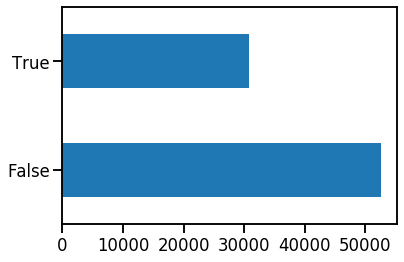

In [30]:
y_train.value_counts().plot.barh();

In [31]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

N_FEATURES = 20
RND = 722
rfe = RFE(
    estimator = DecisionTreeClassifier(
        random_state = RND
    ),
    n_features_to_select = N_FEATURES
)

rfe.fit(X_train, y_train)

RFE(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     presort='deprecated', random_state=722,
                                     splitter='best'),
    n_features_to_select=20, step=1, verbose=0)

In [32]:
mask_rfe_features = rfe.get_support()

print("{} important features".format(N_FEATURES))
print(X_train.columns[mask_rfe_features])

X_train_rfe = X_train[(X_train.columns[mask_rfe_features])]
X_test_rfe = X_test[(X_test.columns[mask_rfe_features])]

20 important features
Index(['LeadTime', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'DaysInWaitingList', 'ADR', 'HasChild', 'RequireCarPark',
       'HasSpecialRequest', 'IsReservedRoomTypeEqualToAssigned', 'IsCityHotel',
       'Meal_BB', 'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'DistributionChannel_Direct', 'CustomerType_Transient'],
      dtype='object')


## 4.2. Project the Data

### 4.2.1. Transform the values

Log transformation on LeadTime & ADR

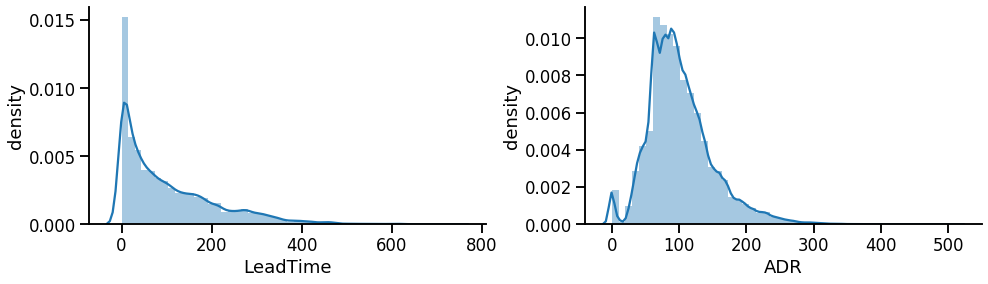

In [33]:
## before log transformation
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.distplot(
    df_hotel['LeadTime'],
    ax = ax[0]
);

sns.distplot(
    df_hotel['ADR'],
    ax = ax[1]
);

ax[0].set_ylabel('density')
ax[1].set_ylabel('density')
sns.despine();

In [34]:
df_hotel['LeadTime'] = np.log(df_hotel['LeadTime'] + 1) ## to prevent division by zero
df_hotel['ADR'] = np.log(df_hotel['ADR'] + 1) ## to prevent division by zero

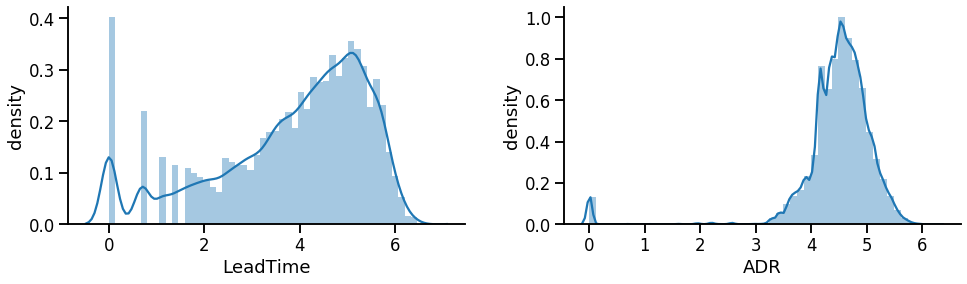

In [35]:
## after log transformation
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

sns.distplot(
    df_hotel['LeadTime'],
    ax = ax[0]
);

sns.distplot(
    df_hotel['ADR'],
    ax = ax[1]
);

ax[0].set_ylabel('density')
ax[1].set_ylabel('density')
sns.despine();

### 4.2.2. Balance the dataset

Oversample the **training set** using SMOTE.

In [36]:
from imblearn.over_sampling import SMOTE

RND = 722
smote = SMOTE(random_state = RND, k_neighbors = 13)

X_train_smote, y_train_smote = smote.fit_resample(X_train_rfe, y_train)

In [37]:
print("Training data before SMOTE: {:,.0f} records".format(X_train.shape[0]))
print("Training data after SMOTE: {:,.0f} records".format(X_train_smote.shape[0]))

Training data before SMOTE: 83,568 records
Training data after SMOTE: 105,342 records


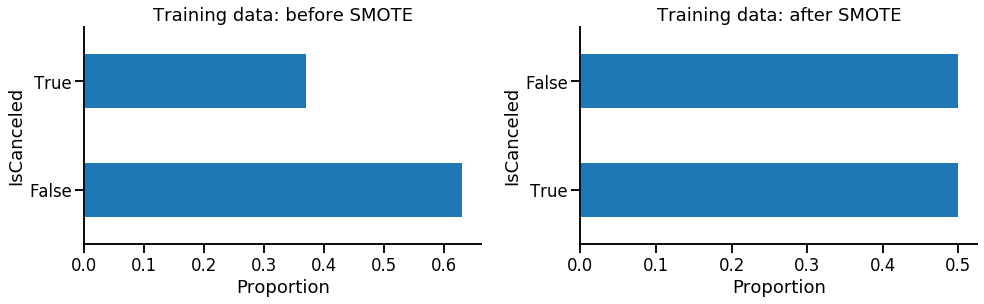

In [38]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

y_train.value_counts(True).plot.barh(ax = ax[0]);
y_train_smote.value_counts(True).plot.barh(ax = ax[1]);

ax[0].set_title("Training data: before SMOTE")
ax[0].set_ylabel("IsCanceled")
ax[0].set_xlabel("Proportion")

ax[1].set_title("Training data: after SMOTE")
ax[1].set_ylabel("IsCanceled")
ax[1].set_xlabel("Proportion")
sns.despine();

Save current train-test-split result and combine the data frame, to be used in the data mining step.

In [39]:
X_train_smote['IsTrainSet'] = 1
X_test_rfe['IsTrainSet'] = 0

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
## also apply log transformation of ADR and LeadTime in X_train_smote and X_test_rfe
X_train_smote['LeadTime'] = np.log(X_train_smote['LeadTime'] + 1) ## to prevent division by zero
X_train_smote['ADR'] = np.log(X_train_smote['ADR'] + 1) ## to prevent division by zero

X_test_rfe['LeadTime'] = np.log(X_test_rfe['LeadTime'] + 1) ## to prevent division by zero
X_test_rfe['ADR'] = np.log(X_test_rfe['ADR'] + 1) ## to prevent division by zero

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
df_hotel_transformed = pd.concat([
    X_train_smote, 
    y_train_smote
], axis = 1)

df_test = pd.concat([
    X_test_rfe,
    y_test
], axis = 1)

df_hotel_transformed = df_hotel_transformed.append(df_test)

In [42]:
df_hotel_transformed.to_csv("hotel_merged_data_transformation.csv", index = False)

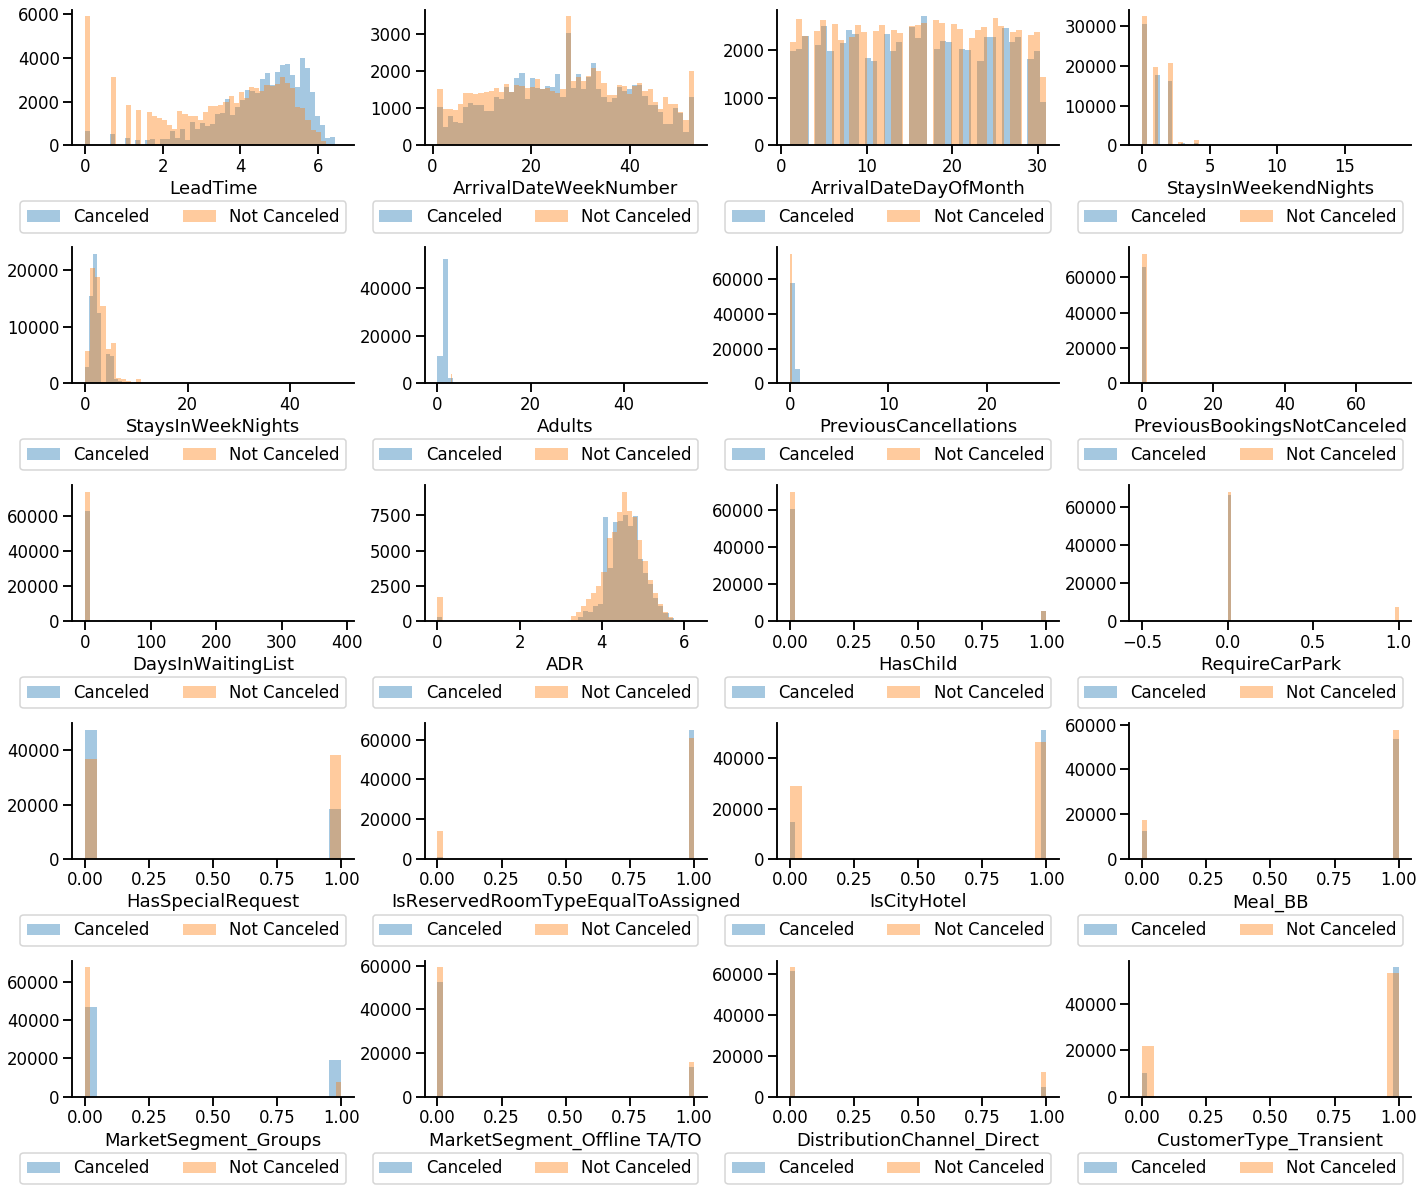

In [43]:
## plot the distribution of current dataset
cols = df_hotel_transformed.columns
cols = cols.drop(labels = ['IsTrainSet','IsCanceled'])

f, ax = plt.subplots(figsize = (24, 20), ncols = 4, nrows = 5)
plt.subplots_adjust(wspace = .25, hspace = .75)

i = 0
j = 0

for col in cols:
    for flag in [True, False]:
        mask = (df_hotel_transformed['IsCanceled'] == flag)
        if flag:
            txt = 'Canceled'
        else:
            txt = 'Not Canceled'
            
        sns.distplot(
            df_hotel_transformed[mask][col],
            kde = False,
            label = txt,
            ax = ax[i][j]
        )
        
    ax[i][j].legend(bbox_to_anchor = [1, -.35], ncol = 2)
    
    if j == 3:
        i += 1
        j = 0
    else:
        j += 1
        
sns.despine();